In [2]:
import torch
from torcheeg.models import EEGNet

# from scipy.io import loadmat
from mat4py import loadmat as mat_loadmat
from hdf5storage import loadmat as hdf5_loadmat

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import glob
import re

import os
import sys

import pickle

from tqdm import tqdm

# EEGNet Model

In [3]:
model = EEGNet(chunk_size=128,
               num_electrodes=32,
               dropout=0.5,
               kernel_1=64,
               kernel_2=16,
               F1=8,
               F2=16,
               D=2,
               num_classes=2)

In [4]:
model

EEGNet(
  (block1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
    (1): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Conv2dWithConstraint(8, 16, kernel_size=(32, 1), stride=(1, 1), groups=8, bias=False)
    (3): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=(1, 4), stride=4, padding=0)
    (6): Dropout(p=0.5, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=16, bias=False)
    (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=8, padding=0)
    (5): Dropout(p=0.5, inplace=False)
  )
  (lin): Linear(in_features=64, out_features=2, bias=False)
)

# Exploration

In [2]:
# mat = hdf5_loadmat("/mnt/D/University/Fall 2025/BCI/Dataset/Task1_Preprocessed/ZAB/gip_ZAB_SNR6_EEG.mat")
mat = hdf5_loadmat("/mnt/D/University/Fall 2025/BCI/Dataset/Task1_Preprocessed/ZAB/gip_ZAB_SR1_EEG.mat")

mat.keys()

dict_keys(['EEG', 'auto_badchans', 'automagic', 'ica_rejected', 'is_interpolated', 'man_badchans', 'params', 'rate', 'tobe_interpolated'])

In [145]:
mat["EEG"].dtype

dtype([('setname', '<U24', (1, 1)), ('filename', '<U1', (0, 0)), ('filepath', '<U1', (0, 0)), ('subject', '<U1', (0, 0)), ('group', '<U1', (0, 0)), ('condition', '<U1', (0, 0)), ('session', '<f8', (0, 0)), ('comments', '<U82', (1, 1)), ('nbchan', '<f8', (1, 1)), ('trials', '<f8', (1, 1)), ('pnts', '<f8', (1, 1)), ('srate', '<f8', (1, 1)), ('xmin', '<f8', (1, 1)), ('xmax', '<f8', (1, 1)), ('times', '<f8', (1, 122182)), ('data', '<f4', (105, 122182)), ('icaact', '<f8', (0, 0)), ('icawinv', '<f8', (85, 14)), ('icasphere', '<f8', (85, 85)), ('icaweights', '<f8', (14, 85)), ('icachansind', '<f8', (1, 85)), ('chanlocs', [('labels', 'O'), ('Y', '<f8', (1, 1)), ('X', '<f8', (1, 1)), ('Z', '<f8', (1, 1)), ('sph_theta', '<f8', (1, 1)), ('sph_phi', '<f8', (1, 1)), ('sph_radius', '<f8', (1, 1)), ('theta', '<f8', (1, 1)), ('radius', '<f8', (1, 1)), ('type', '<U1', (0, 0)), ('ref', '<U1', (0, 0)), ('urchan', '<f8', (1, 1))], (1, 105)), ('urchanlocs', '<f8', (0, 0)), ('chaninfo', [('filename', '<U20'

In [146]:
mat["EEG"]["data"].shape

(1, 105, 122182)

In [147]:
mat["EEG"]["times"][0,0,:10]

array([-0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.])

In [148]:
mat["EEG"]["nbchan"], mat["EEG"]["srate"], mat["EEG"]["chanlocs"].shape

(array([[[105.]]]), array([[[500.]]]), (1, 1, 105))

In [149]:
np.array(mat["EEG"]["chanlocs"][0,0,0])
# [["X", "Y", "Z"]]

array((array([['E2']], dtype='<U2'), [[-5.29180473]], [[6.70909756]], [[0.3074349]], [[-38.26463186]], [[2.06054405]], [[8.55042125]], [[38.26463186]], [[0.48855253]], [], [], [[5.]]),
      dtype=[('labels', 'O'), ('Y', '<f8', (1, 1)), ('X', '<f8', (1, 1)), ('Z', '<f8', (1, 1)), ('sph_theta', '<f8', (1, 1)), ('sph_phi', '<f8', (1, 1)), ('sph_radius', '<f8', (1, 1)), ('theta', '<f8', (1, 1)), ('radius', '<f8', (1, 1)), ('type', '<U1', (0, 0)), ('ref', '<U1', (0, 0)), ('urchan', '<f8', (1, 1))])

In [150]:
mat["EEG"]["event"][0,0,:5]["latency"]

array([[[  24.]],

       [[1040.]],

       [[4380.]],

       [[4387.]],

       [[7798.]]])

In [151]:
EEG = mat["EEG"]

# === Basic info ===
fs = EEG["srate"].item()                 # Sampling rate
data = EEG["data"]                       # Shape (n_channels, n_samples)
events = EEG["event"].squeeze()          # List of event structs
times = EEG["times"].squeeze()           # Time vector (ms)

event_types = events["type"].squeeze()
event_latencies = events["latency"].squeeze().astype(np.int32)

print(f"EEG shape: {data.shape}, Fs={fs} Hz, #Events={len(events)}")

EEG shape: (1, 105, 122182), Fs=500.0 Hz, #Events=108


In [152]:
start_indices = event_latencies[event_types == "10  "]
end_indices = event_latencies[event_types == "11  "]

sentence_eegs = []
for i, (start, end) in enumerate(zip(start_indices, end_indices)):
    segment = data[0, :, start:end]   # shape: (n_channels, segment_length)
    sentence_eegs.append({
        "sentence_index": i,
        "eeg": segment,
        "start_sample": start,
        "end_sample": end,
        "duration_sec": (end - start) / fs
    })

print(f"Extracted EEG for {len(sentence_eegs)} sentences")

Extracted EEG for 41 sentences


[np.float32(67.96444),
 np.float32(69.255455),
 np.float32(69.339905),
 np.float32(71.69381),
 np.float32(97.291275)]

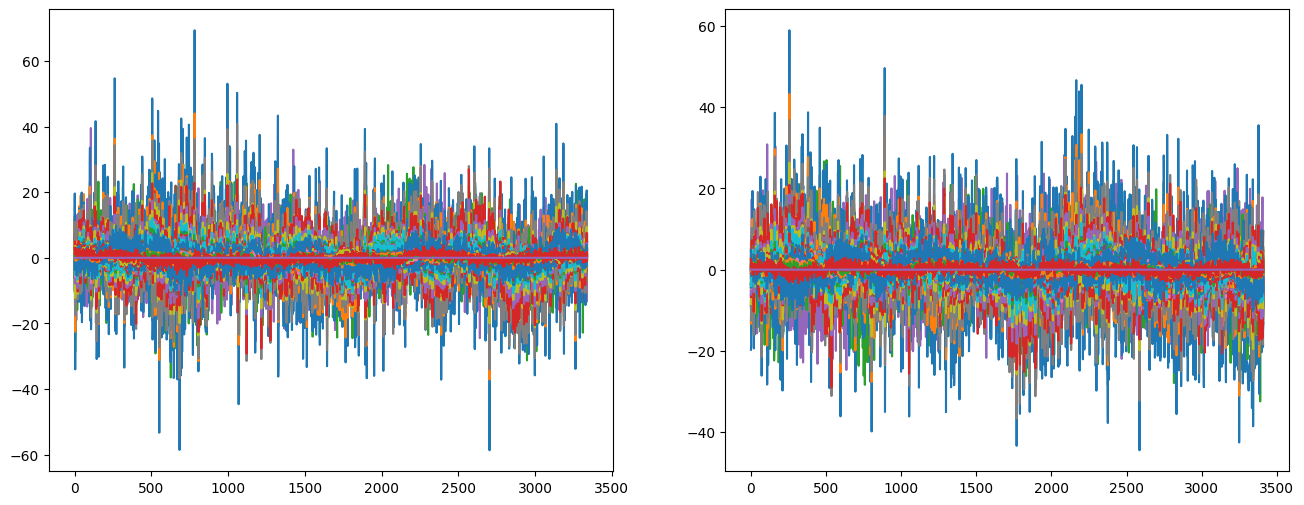

In [153]:
maxes = []
for _ in range(len(sentence_eegs)):
    maxes.append(sentence_eegs[_]["eeg"].max())

plt.figure(figsize=(16,6))
for ch in range(105):
    plt.subplot(1,2,1)
    plt.plot(sentence_eegs[0]["eeg"][ch]);
    plt.subplot(1,2,2)
    plt.plot(sentence_eegs[1]["eeg"][ch])

maxes.sort()
maxes[-5:]

In [3]:
snr = pd.read_csv("/mnt/D/University/Fall 2025/BCI/Dataset/Task1_Preprocessed/sentiment_normal_reading.csv", sep=";")
snr

,ID,sentence,control
0,1,One of the best silly horror movies of recent ...,NaN
1,2,Jason Patric and Ray Liotta make for one splen...,NaN
2,13,"A real winner -- smart, funny, subtle, and res...",CONTROL
3,3,It's hard to imagine acting that could be any ...,CONTROL
4,4,This is more a case of `Sacre bleu!',NaN
...,...,...,...
595,596,"A very well-made, funny and entertaining picture.",CONTROL
596,597,"The power of this script, and the performances...",NaN
597,598,"unpretentious, charming, quirky, original",CONTROL
598,599,What emerges is an unsettling picture of child...,NaN


In [12]:
snr["sentence"].str.len().max()

np.int64(255)

# Data Collection

In [14]:
mat = hdf5_loadmat("/mnt/D/University/Fall 2025/BCI/Dataset/Task1_Preprocessed/sentencesSR.mat")
mat2 = hdf5_loadmat("/mnt/C/BCI Dataset/Task2_Preprocessed/sentencesNR.mat")
mat3 = hdf5_loadmat("/mnt/C/BCI Dataset/Task3_Preprocessed/sentencesTSR.mat")

mat.keys(), mat2.keys(), mat3.keys()

(dict_keys(['__header__', '__version__', '__globals__', 'sentences']),
 dict_keys(['__header__', '__version__', '__globals__', 'sentences']),
 dict_keys(['__header__', '__version__', '__globals__', 'sentences']))

In [33]:
sentences1 = np.array(mat["sentences"]).squeeze()
sentences2 = np.array(mat2["sentences"]).squeeze()
sentences3 = np.array(mat3["sentences"]).squeeze()

sentences1.shape, sentences2.shape, sentences3.shape, sentences1[:5]

((600,),
 (595,),
 (407,),
 array([array(['One of the best silly horror movies of recent memory, with some real shocks in store for unwary viewers.'],
              dtype='<U104')                                                                                               ,
        array(['Jason Patric and Ray Liotta make for one splendidly cast pair.'],
              dtype='<U62')                                                      ,
        array(['A real winner -- smart, funny, subtle, and resonant.'],
              dtype='<U52')                                            ,
        array(["It's hard to imagine acting that could be any flatter."],
              dtype='<U54')                                              ,
        array(["This is more a case of `Sacre bleu!'"], dtype='<U36')],
       dtype=object))

In [31]:
def read_eeg_file(filepath, sentences, sentence_offset=0):
    mat = hdf5_loadmat(filepath)
    
    EEG = mat["EEG"]

    # === Basic info ===
    fs = EEG["srate"].item()                 # Sampling rate
    data = EEG["data"]                       # Shape (n_channels, n_samples)
    events = EEG["event"].squeeze()          # List of event structs
    times = EEG["times"].squeeze()           # Time vector (ms)

    try:
        event_types = events["type"].squeeze()
        event_latencies = events["latency"].squeeze().astype(np.int32)
    except:
        data = data.item()
        data = data.reshape(1,*data.shape)
        events = events.item()
        event_types = events["type"].squeeze()
        event_latencies = events["latency"].squeeze().astype(np.int32)

    # print(f"EEG shape: {data.shape}, Fs={fs} Hz, #Events={len(events)}")

    start_indices = event_latencies[event_types == "10  "]
    end_indices = event_latencies[event_types == "11  "]

    sentence_eegs = []
    for i, (start, end) in enumerate(zip(start_indices, end_indices)):
        segment = data[0, :, start:end]   # shape: (n_channels, segment_length)
        sentence_eegs.append({
            "sentence_index": i+sentence_offset,
            "sentence": sentences[i+sentence_offset].item(),
            "eeg": segment,
            "start_sample": start,
            "end_sample": end,
            "duration_sec": (end - start) / fs
        })

    # print(f"Extracted EEG for {len(sentence_eegs)} sentences")

    return sentence_eegs

def get_ordered_eeg_files(folder):
    folder = os.path.abspath(folder)
    eeg_files = []

    # Regex to capture numbers like SR1, SNR6, SR12 etc.
    pattern = re.compile(r'(?:SNR|SR|NR|TSR)(\d+)', re.IGNORECASE)

    for file in glob.glob("*EEG.mat", root_dir=folder):
        match = pattern.search(file)
        if match:
            number = int(match.group(1))
            eeg_files.append((number, os.path.join(folder,file)))

    # Sort by the extracted number
    eeg_files.sort(key=lambda x: x[0])

    # Return only the paths
    return [path for _, path in eeg_files]

def get_subjects(task_dir):
    res = []
    for item in os.listdir(task_dir):
        item_path = os.path.join(task_dir, item)
        if os.path.isdir(item_path):
            res.append((item, item_path))
    
    return res

In [ ]:
subject_eegs = {}

# top_dir = "/mnt/D/University/Fall 2025/BCI/Dataset/Task1_Preprocessed"
# sentences = sentences1

top_dir = "/mnt/C/BCI Dataset/Task2_Preprocessed"
sentences = sentences2

# top_dir = "/mnt/C/BCI Dataset/Task3_Preprocessed"
# sentences = sentences3

for subject_name, subject_dir in get_subjects(top_dir):
    sentences_eegs = []
    offset = 0
    for file in tqdm(get_ordered_eeg_files(subject_dir)):
        tmp = read_eeg_file(file, sentences, offset)
        offset += len(tmp)
        sentences_eegs += tmp

    subject_eegs[subject_name] = sentences_eegs

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:16<00:00,  1.79s/it]


In [11]:
for subject in subject_eegs:
    print(len(subject_eegs[subject]))

335
335


In [ ]:
with open("subject_eegs_task1.pkl", "wb") as f:
    pickle.dump(subject_eegs, f)

OSError: [Errno 28] No space left on device